<a href="https://colab.research.google.com/github/jaewonlee16/Introduction-to-Deep-Learning/blob/master/hw1/2023_SNU_DL_HW1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1: Linear classifier (numpy)

In this exercise, we will learn to implement a Linear classifier using numpy modules. The goal here is to show the basic concepts of classification and to learn how to implement
forward/backward propagation of operations used in Linear classifier.

You will be asked to complete several functions/classes used below in `HW_YourAnswer.py`.

- `softmax`
- `cross_entropy_loss`
- `linear_predict`
- `linear_cost_func`
- `batch_gradient_descent_func`
- `stochastic_gradient_descent_func`

First, let's check if you are properly using GPU
- Ouput should be 'True'
- If not, please follow the instructions in ETL.

In [1]:
import torch
use_cuda = torch.cuda.is_available()
print('GPU available?:', use_cuda)

GPU available?: True


Next, let's mount your drive directory to current notebook and change the system directory to your working directory

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Intro_dl/hw1')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Intro_dl/hw1')

Mounted at /content/drive


In [4]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image
from utils import *
from HW_YourAnswer import *

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Random Seed

In [5]:
seed = 0
np.random.seed(seed)

## Data preprocessing

We will use the CIFAR10 dataset.

CIFAR10 dataset is composed of 50000 train data and 10000 test data but we will only use 10000, 1000 images each.

In [6]:
# 10000 images for training data and 1000 images for test data
# 'get_cifar10_data()' returns train/test data with its mean subtracted for training
X_tr, Y_tr, X_te, Y_te, mean_img = get_CIFAR10_data()
print ('Train data shape : %s,  Train labels shape : %s' % (X_tr.shape, Y_tr.shape))
print ('Test data shape : %s,  Test labels shape : %s' % (X_te.shape, Y_te.shape))

nb_classes = 10

# one-hot encode labels from integers(0, 1, .., 9) to 10-dim one-hot vector
train_targets = Y_tr.reshape(-1)
Y_tr_onehot = np.eye(nb_classes)[train_targets]

test_targets = Y_te.reshape(-1)
Y_te_onehot = np.eye(nb_classes)[test_targets]

Train data shape : (10000, 3072),  Train labels shape : (10000,)
Test data shape : (1000, 3072),  Test labels shape : (1000,)


## Visualize training images

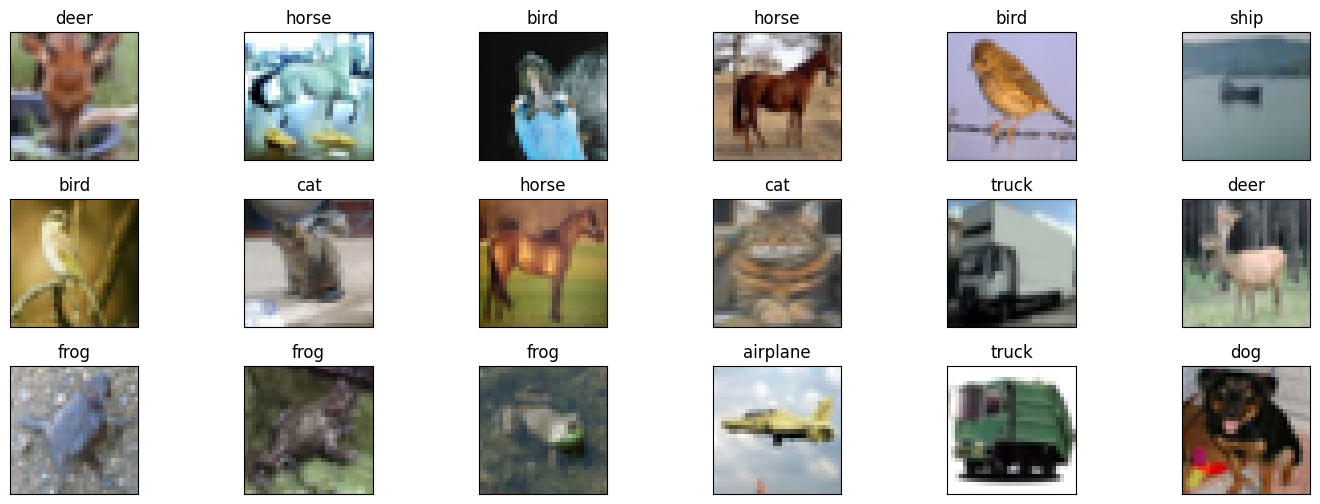

In [6]:
# list of classes for cifar10
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# random data idx for visualization
images_index = np.int32(np.round(np.random.rand(18,)*10000,0))

fig, axes = plt.subplots(3, 6, figsize=(18, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, idx in zip(axes.flat, images_index):
    # mean is added again to restore original image
    img = (X_tr[idx,:3072].reshape(32, 32, 3) + mean_img.reshape(32, 32, 3))
    ax.imshow(img)
    ax.set_title(class_names[Y_tr[idx]])


## 1. Softmax function

### To do:
- Implement `softmax` in `HW_YourAnswer.py` file <br>

<center>

$$
\Large p(\mathbf{Y}=k|\mathbf{X}=x) =  \Large \frac{exp(\mathbf{s_{k}})} {\Sigma_{j=1}^{K} exp(s_{j})}
$$
(p.21 Leture 4)


- The output should be [2.06115362e-09 1.80485138e-35 9.99999998e-01]
- Sum of the softmax output should be 0.9999999999999999
- It should not be NaN

In [7]:
temp_x = np.array([[2060,2000,2080]])
softmax_result1 = softmax(temp_x)
print('Softmax result :\n',softmax_result1)
print ('\nSum of the softmax :',np.sum(softmax_result1))

Softmax result :
 [[2.06115362e-09 1.80485138e-35 9.99999998e-01]]

Sum of the softmax : 0.9999999999999999


- The output should be <br>
    [2.06115362e-09   1.80485138e-35   9.99999998e-01] <br>
    [2.06106005e-09   4.53978686e-05   9.99954600e-01]]

- Sum of the softmax output should be [1. 1.]

In [8]:
temp_x = np.array([[2060,2000,2080],[1010,1020,1030]])
softmax_result2 = softmax(temp_x)
print('Softmax result :\n',softmax_result2)
print ('\nSum of the softmax :',np.sum(softmax_result2,axis=1))

Softmax result :
 [[2.06115362e-09 1.80485138e-35 9.99999998e-01]
 [2.06106005e-09 4.53978686e-05 9.99954600e-01]]

Sum of the softmax : [1. 1.]


## 2. Cross-Entropy Loss
Here, we will consider cross-entropy loss between the true target value(e.g., 1) and prediced value after softmax.
Note that Negative log-likelihood for the true class and cross entropy between true target  and prediction has a similar formula (Lecture 4 p.23).

### To do:
- Implement `cross_entropy_loss` in `HW_YourAnswer.py` file

<center>

$$
\Large L(W) = \frac{1}{N} \Sigma_{i=1}^{N} L_{i}{(s_{i},y_{i})}
$$
    where

$$
L_{i}{(s_{i},y_{i})} = \frac{exp(\mathbf{s_{y_{i}}})} {\Sigma_{j=1}^{K} exp(s_{j})}
\\
 N : \text{number of data}
\\
s_{i} : \text{softmax score for } i^{th} \text{ class}
$$

<br> NOTE: cross entropy loss is __averaged__ w.r.t the number of data

- The output should be 20.72326583694641
- It should not be NaN

In [9]:
temp_score0 = np.array([[0.0, 0.0, 0.0]])
temp_target0 = np.array([[0,1,0]])
loss0 = cross_entropy_loss(temp_score0, temp_target0)
print('Total Loss for temp_0 =', loss0)

Total Loss for temp_0 = 20.72326583694641


- The output should be 1.2039728009926025
- It should not be NaN

In [10]:
temp_score1 = np.array([[0.1, 0.3, 0.6]])
temp_target1 = np.array([[0,1,0]])
loss1 = cross_entropy_loss(temp_score1, temp_target1)
print('Total Loss for temp_1 =', loss1)

Total Loss for temp_1 = 1.2039728009926025


- The output should be 0.7418746816378242
- It should not be NaN

In [11]:
temp_score2 = np.array([[0.1, 0.3, 0.6],[0.2,0.4,0.4],[0.9,0.05,0.05]])
temp_target2 = np.array([[0,1,0],[0,0,1],[1,0,0]])
loss2 = cross_entropy_loss(temp_score2, temp_target2)
print('Total Loss for temp_2 =', loss2)

Total Loss for temp_2 = 0.7418746816378242


## 3. Linear classifier

With several functions we've defined above, we will implement Linear classifier learned in Lecture 5 p.31-35.

One thing to note is that the __column__ of weight matrix indicates weight for each class, which is different from notations used in the Lecture slides.
$$
W_{i}: i^{th} \text{column of the matrix } = \text{ classifier for class } i
$$
So, the score(before softmax) will be computed as
$$
XW+b
$$

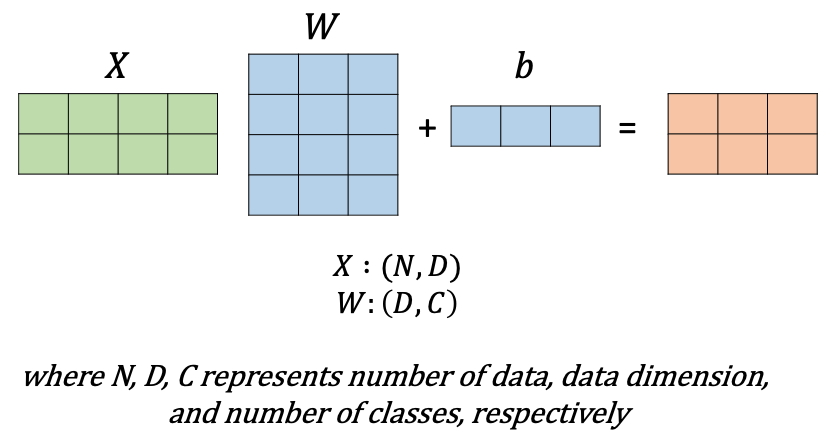

In [12]:
Image('fig/Affine_Layer_pic.png')

## To do:
- Implement `linear_predict`, `linear_cost_func`, `batch_gradient_descent_func` in `HW_YourAnswer.py` file.

In [13]:
# Use only 20 data for example
x_batch = X_tr[:20]
y_batch = Y_tr_onehot[:20]

print ('Train data shape : %s,  Train labels shape : %s' % (x_batch.shape, y_batch.shape))


# Initialize weights & bias
W = np.zeros((3072, 10))
b = np.zeros((10))

# Parameters for the gradient descent
iterations = 100
alpha = 0.1

Train data shape : (20, 3072),  Train labels shape : (20, 10)


- cost shoule be 2.302585082994045

In [14]:
initial_cost = linear_cost_func(x_batch, y_batch, W, b)
print('loss:', initial_cost)

loss: 2.302585082994045


- final loss should be 0.018715975170939064

In [15]:
s_time = time.time()

W_batch, _, J_his_batch, W_his_batch = batch_gradient_descent_func(x_batch, y_batch, W, b, alpha, iterations)
print ('final loss : {} with {:.3f}s'.format(J_his_batch[-1], time.time()-s_time))

#print(J_his_batch[-3:])

final loss : 0.01871597517093907 with 0.053s


Since we only use 20 data for practice, the loss curve drops dramatically in few iterations

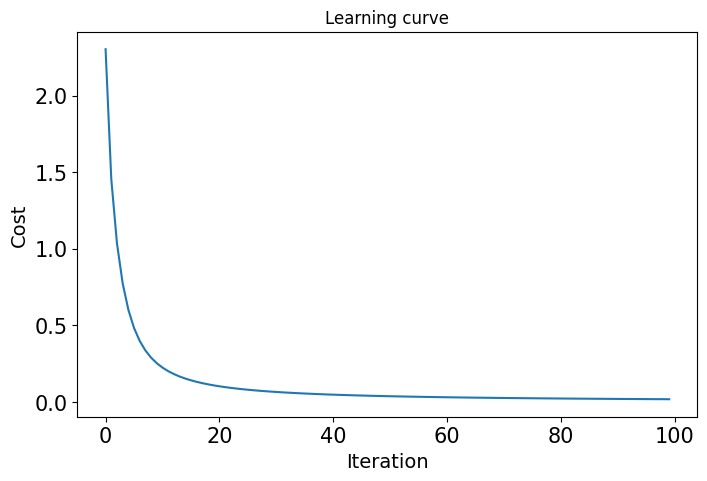

In [16]:
plotCostOpt(J_his_batch)

## To do:
- Implement `stochastic_gradient_descent_func` in `HW_YourAnswer.py` file.
- Due to randomness, the returned loss may be slightly different from the loss described in the script.

In [17]:
# Initialize weights and biases
W = np.zeros((3072, 10))
b = np.zeros((10))

- Final loss should be 0.005614035128227841 (It doens't have to be exactly the same)

In [22]:
random_seed = 7
mini_batch = 2

W_SGD, _, J_his_SGD, W_his_SGD = stochastic_gradient_descent_func(x_batch, y_batch, W, b, alpha, iterations, mini_batch, random_seed)
print ('final loss : {} with {:.3f}s'.format(J_his_SGD[-1], time.time()-s_time))

final loss : 0.005614035128227819 with 68.736s


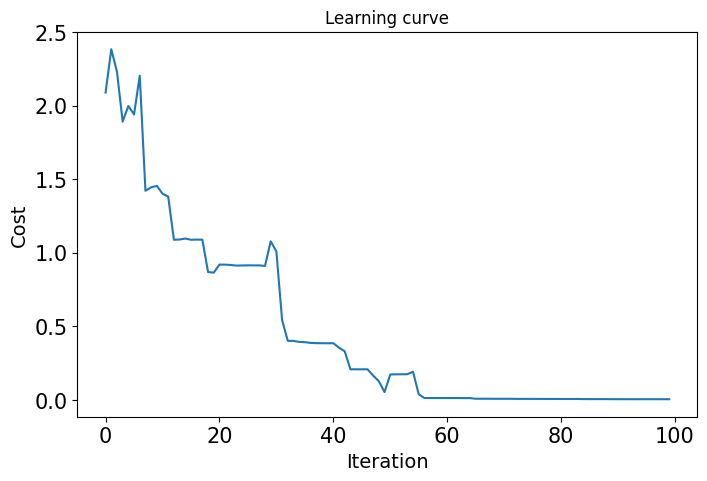

In [23]:
plotCostOpt(J_his_SGD)

## Visualize the learned classifier

Let's see the performance of our linear classifier trained with all the training data. Also, by rescaling the weight parameters, we can visuailize the learned weights for each class

In [24]:
# Now use all the data to train our linear classifier

# 1. Training dataset
train_X = X_tr
train_Y = Y_tr_onehot

# 2. Test dataset
test_X = X_te
test_Y = Y_te

print ('Train data shape : %s,  Train labels shape : %s' % (train_X.shape, train_Y.shape))
print ('Test data shape : %s,  Test labels shape : %s' % (test_X.shape, test_Y.shape))

# 3. Training details
W = np.zeros((3072, 10))
b = np.zeros((10))
alpha = 0.01
iterations = 3000
mini_batch = 10

# 4. Train
W_SGD, b_SGD, J_his_SGD, W_his_SGD = stochastic_gradient_descent_func(train_X, train_Y, W, b, alpha, iterations, mini_batch, random_seed)


Train data shape : (10000, 3072),  Train labels shape : (10000, 10)
Test data shape : (1000, 3072),  Test labels shape : (1000,)


- Using `linear_pred` which should be already implemented, let's evaluate on test data
- Test acc should be about 0.383

In [25]:
pred = np.argmax(linear_pred(test_X, W_SGD, b_SGD), axis=1)
print('Test acc : ', np.sum(pred==test_Y)/len(pred))

Test acc :  0.383


Let's visualize the learned weight of each classes

Since our model is not that accurate, these may not look nice

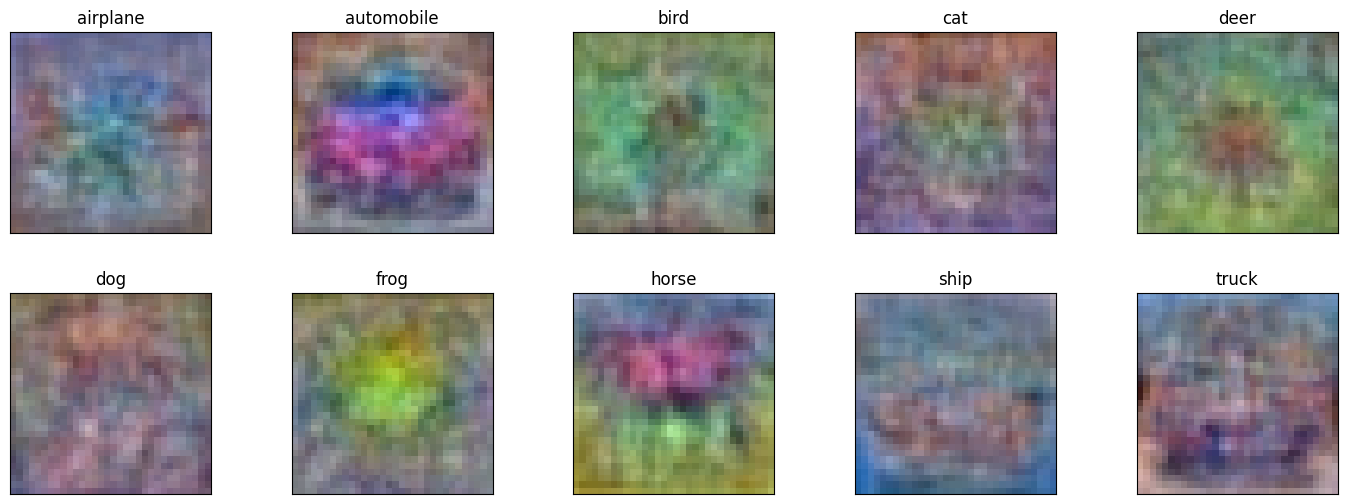

In [26]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']


w = W_SGD[:,:].reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)

images_index = np.int32(np.round(np.random.rand(10,)*10000,0))

w_min, w_max = np.min(w), np.max(w)

fig, axes = plt.subplots(2, 5, figsize=(18, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)
# print(w_min, w_max, visualize_theta)

for idx, ax in enumerate(axes.flat):
    wimg = 255.0 * (w[:, :, :, idx].squeeze() - w_min) / (w_max - w_min)
    img = (wimg.reshape(32, 32, 3))
    ax.imshow(img.astype('uint8'))
    ax.set_title(class_names[idx])


# Exercise 2: Neural Network Modules (Numpy)

In this exercise, we will learn to implement a Twolayer Neural Network using numpy modules. The goal here is to learn how to implement forward/backward propagation of each operations used in Neural Network and how to modularize each operations.

You will be asked to complete several functions/classes used below in `HW_YourAnswer.py`.

- `OutputLayer`
- `ReLU`
- `Sigmoid`
- `Affine`
- `TwoLayerNet`

## 1. Output Layer

Now let's consider output layer that forwards cross entropy loss with given score and target in class.

### To do:
- Implement `OutputLayer` in `HW_YourAnswer.py` file

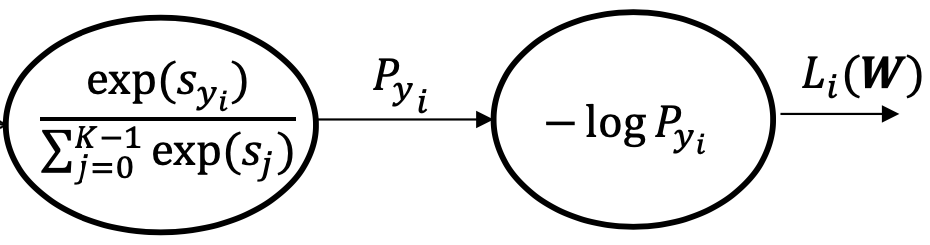

In [27]:
Image('fig/Output_Layer.png')

In [28]:
outputlayer = OutputLayer()

- Forward output should be 13.095060867144417
- Backward output should be [ 0.90887517 -0.99999795  0.09112277]

In [29]:
temp_x1 = np.array([[3, -10, 0.7]])
temp_t1 = np.array([[0,1,0]])
output_forward1 = outputlayer.forward(temp_x1, temp_t1)
output_backward1 = outputlayer.backward()
print('Forward propagation of output layer :', output_forward1)
print('Backward propagation of output layer :', output_backward1)

Forward propagation of output layer : 13.095060867144417
Backward propagation of output layer : [[ 0.90887517 -0.99999795  0.09112277]]


- Forward output should be 7.075548386844261
- Backward output should be [ 3.02958391e-01, -3.33332649e-01,  3.03742579e-02],
       [-3.32509126e-01,  3.32509088e-01,  3.74189683e-08],
       [ 7.26173786e-04,  2.92959414e-01, -2.93685588e-01]]

In [30]:
temp_x2 = np.array([[3, -10, 0.7],[9,15,-1],[-5,1,-1]])
temp_t2 = np.array([[0,1,0],[1,0,0],[0,0,1]])
output_forward2 = outputlayer.forward(temp_x2, temp_t2)
output_backward2 = outputlayer.backward()
print('Forward propagation of output layer :', output_forward2)
print('\nBackward propagation of output layer :', output_backward2)

Forward propagation of output layer : 7.075548386844261

Backward propagation of output layer : [[ 3.02958391e-01 -3.33332649e-01  3.03742579e-02]
 [-3.32509126e-01  3.32509088e-01  3.74189683e-08]
 [ 7.26173786e-04  2.92959414e-01 -2.93685588e-01]]


# 2. ReLU

### To do:
- Implement `ReLU` in `HW_YourAnswer.py` file <br><br>

<center>

$$
\Large ReLU(x) =  max(0,x)
$$

In [31]:
relu = ReLU()

- Forward propagation should be [3.  0.  0.7]
- Backward propagation should be [-10   0   0]

In [32]:
temp_x1 = np.array([[3, -10, 0.7]])
temp_x2 = np.array([[-10,1,0]])
relu_forward1 = relu.forward(temp_x1)
relu_backward1 = relu.backward(temp_x2)
print('Forward propagation of ReLU :', relu_forward1)
print('Backward propagation of ReLU :', relu_backward1)

Forward propagation of ReLU : [[ 3.  -0.   0.7]]
Backward propagation of ReLU : [[-10   0   0]]


- Forward propagation should be
            [ 3. ,  0. ,  0.7],
            [ 9. , 15. ,  0. ],
            [ 0. ,  1. ,  0. ]
<br>
- Backward propagation should be
            [  3,   0, -10],
            [  5,  -4,   0],
            [  0,  -5,   0]

In [33]:
temp_x3 = np.array([[3, -10, 0.7],[9,15,-1],[-5,1,-1]])
temp_x4 = np.array([[3,5,-10],[5,-4,2],[-3,-5,3]])
relu_forward2 = relu.forward(temp_x3)
relu_backward2 = relu.backward(temp_x4)
print('Forward propagation of ReLU :', relu_forward2)
print('\nBackward propagation of ReLU :', relu_backward2)

Forward propagation of ReLU : [[ 3.  -0.   0.7]
 [ 9.  15.  -0. ]
 [-0.   1.  -0. ]]

Backward propagation of ReLU : [[  3   0 -10]
 [  5  -4   0]
 [  0  -5   0]]


# 3. Sigmoid

### To do:
- Implement `Sigmoid` in `HW_YourAnswer.py` file <br><br>

<center>

$$
\Large  \sigma(x) =  \frac{1}{1+exp^{-x}}
$$

In [34]:
sigmoid = Sigmoid()

- Forward propagation output should be [9.52574127e-01 4.53978687e-05 6.68187772e-01]
- Backward propagation output should be [ 0.13552998 -0.00045396  0.15519901]

In [35]:
temp_x1 = np.array([[3, -10, 0.7]])
sigmoid_forward1 = sigmoid.forward(temp_x1)
sigmoid_backward1 = sigmoid.backward(temp_x1)
print('Forward propagation of sigmoid :',sigmoid_forward1)
print('Backward propagation of sigmoid :',sigmoid_backward1)

Forward propagation of sigmoid : [[9.52574127e-01 4.53978687e-05 6.68187772e-01]]
Backward propagation of sigmoid : [[ 0.13552998 -0.00045396  0.15519901]]


- Forward propagation output should be <br>
   [9.52574127e-01 4.53978687e-05 6.68187772e-01], <br>
   [9.99876605e-01 9.99999694e-01 2.68941421e-01], <br>
   [6.69285092e-03 7.31058579e-01 2.68941421e-01]

- Backward propagation output should be  <br>
 [ 1.35529979e-01 -4.53958077e-04  1.55199011e-01], <br>
 [ 1.11041415e-03  4.58853200e-06 -1.96611933e-01], <br>
 [-3.32402834e-02  1.96611933e-01 -1.96611933e-01]

In [36]:
temp_x2 = np.array([[3, -10, 0.7],[9,15,-1],[-5,1,-1]])
sigmoid_forward2 = sigmoid.forward(temp_x2)
sigmoid_backward2 = sigmoid.backward(temp_x2)
print('Forward propagation of sigmoid :',sigmoid_forward2)
print('\nBackward propagation of sigmoid :',sigmoid_backward2)

Forward propagation of sigmoid : [[9.52574127e-01 4.53978687e-05 6.68187772e-01]
 [9.99876605e-01 9.99999694e-01 2.68941421e-01]
 [6.69285092e-03 7.31058579e-01 2.68941421e-01]]

Backward propagation of sigmoid : [[ 1.35529979e-01 -4.53958077e-04  1.55199011e-01]
 [ 1.11041415e-03  4.58853200e-06 -1.96611933e-01]
 [-3.32402834e-02  1.96611933e-01 -1.96611933e-01]]


# 4. Affine

### To do:
- Implement `Affine` in `HW_YourAnswer.py` file <br><br>
- __Note__ : bias is added seperately.

<center>   

$$
Affine(W,b) =  XW + b
$$

- Note that the matrix multiplication are implemented in XW not WX which are different from the Lecture slides. Also this time, bias is considered seperately (not included in the weight)

- Forward propagation output should be <br>
[ 0.51 -0.39  0.84] <br>
 [-0.07 -0.02  0.02]

- Backward propagation output should be <br>
[-0.61  0.28] <br>
 [-0.25 -0.21]

In [37]:
temp_W = np.array([[0.2, -0.3, 0.6], [-0.9, 0.1, -0.4]])
temp_b = np.array([[0.2, -0.3, 0.6]])
temp_x = np.array([[0.2, -0.3], [-0.9, 0.1]])
temp_t = np.array([[0.1, 0.5, -0.8], [0.4, 0.7, -0.2]])

affine = Affine(temp_W, temp_b)
affine_forward1 = affine.forward(temp_x)
affine_backward1 = affine.backward(temp_t)
print('Forward propagation of Affine :\n', affine_forward1)
print('\nBackward propagation of Affine :\n', affine_backward1)

Forward propagation of Affine :
 [[ 0.51 -0.39  0.84]
 [-0.07 -0.02  0.02]]

Backward propagation of Affine :
 [[-0.61  0.28]
 [-0.25 -0.21]]


- dW of affine should be <br>
        [-0.34, -0.53,  0.02],
        [ 0.01, -0.08,  0.22]
<br>
- db of affine should be
        [ 0.5,  1.2, -1. ]

In [38]:
dw = affine.dW
db = affine.db
print('Gradient of the weights :\n', dw)
print('\nGradient of the biases :',db)

Gradient of the weights :
 [[-0.34 -0.53  0.02]
 [ 0.01 -0.08  0.22]]

Gradient of the biases : [ 0.5  1.2 -1. ]


# 5. TwoLayerNN

### To do:
- Implement `TwoLayerNet` in `HW_YourAnswer.py` file <br><br>
- Note : Our TwoLayerNN will be using L2-regularization to prevent overfitting.
- Use OrderedDict to make a model (https://pymotw.com/2/collections/ordereddict.html)

### Numerical gradient vs Backpropagation

- Running time of grad_backprop should be much faster than the time of grad_numerical

In [39]:
network = TwoLayerNet(input_size=3072, hidden_size=10, output_size=10, regularization = 100)

x_batch = X_tr[:20]
y_batch = Y_tr_onehot[:20]

start_time = time.time()
grad_backprop = network.gradient(x_batch, y_batch)
print("[grad_backprop] running time(sec) : " +str(time.time() - start_time))

start_time = time.time()
grad_numerical = network.numerical_gradient(x_batch, y_batch)
print("[grad_numerical] running time(sec) : "+str(time.time() - start_time))

[grad_backprop] running time(sec) : 0.002269268035888672
[grad_numerical] running time(sec) : 85.84250950813293


Note that the difference is trivial

In [40]:
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:7.560013093594374e-11
b1:3.5416817148838966e-11
W2:1.0421137166746752e-10
b2:5.76673855109261e-10


Let's train our TwoLayerNet

In [7]:
input_size_=3072
hidden_size_=1024
output_size_=10
regularization_ = 0.0001

network = TwoLayerNet(input_size=input_size_, hidden_size=hidden_size_, output_size=output_size_, regularization = regularization_)

# NOTE: you may change iters_num while debugging your code
# but before submission, please submit the final model trained with 2000 iteratinos.
iters_num = 2000
train_size = X_tr.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list_two = []
train_acc_list_two = []
test_acc_list_two = []

iter_per_epoch = max(train_size / batch_size, 1)

In [8]:
for i in range(iters_num):

    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = X_tr[batch_mask]
    y_batch = Y_tr_onehot[batch_mask]

    _ = network.gradient(x_batch, y_batch)

    network.update_params(learning_rate)

    loss = network.loss(x_batch, y_batch)
    train_loss_list_two.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(X_tr, Y_tr_onehot)
        test_acc = network.accuracy(X_te, Y_te_onehot)
        train_acc_list_two.append(train_acc)
        test_acc_list_two.append(test_acc)

        print("Epoch : ",i / iter_per_epoch + 1, "Training acc : ", round(train_acc,2), "Test acc : ", round(test_acc,2))


Epoch :  1.0 Training acc :  0.15 Test acc :  0.17
Epoch :  2.0 Training acc :  0.35 Test acc :  0.35
Epoch :  3.0 Training acc :  0.4 Test acc :  0.37
Epoch :  4.0 Training acc :  0.44 Test acc :  0.39
Epoch :  5.0 Training acc :  0.46 Test acc :  0.42
Epoch :  6.0 Training acc :  0.49 Test acc :  0.42
Epoch :  7.0 Training acc :  0.51 Test acc :  0.44
Epoch :  8.0 Training acc :  0.53 Test acc :  0.46
Epoch :  9.0 Training acc :  0.55 Test acc :  0.45
Epoch :  10.0 Training acc :  0.58 Test acc :  0.46
Epoch :  11.0 Training acc :  0.59 Test acc :  0.47
Epoch :  12.0 Training acc :  0.61 Test acc :  0.47
Epoch :  13.0 Training acc :  0.64 Test acc :  0.47
Epoch :  14.0 Training acc :  0.65 Test acc :  0.49
Epoch :  15.0 Training acc :  0.67 Test acc :  0.49
Epoch :  16.0 Training acc :  0.69 Test acc :  0.46
Epoch :  17.0 Training acc :  0.69 Test acc :  0.48
Epoch :  18.0 Training acc :  0.71 Test acc :  0.46
Epoch :  19.0 Training acc :  0.74 Test acc :  0.48
Epoch :  20.0 Training

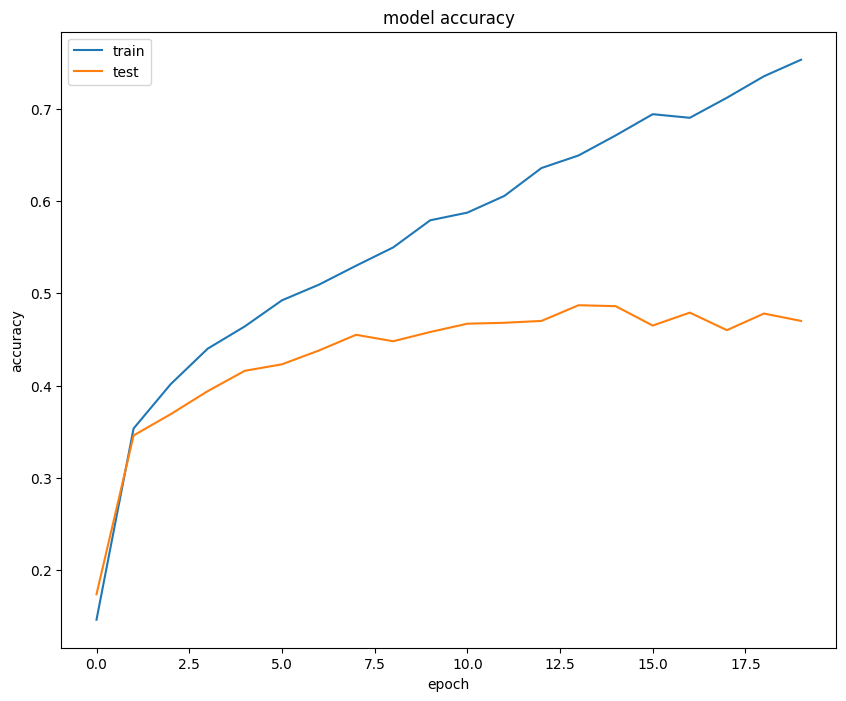

In [9]:
model_plot(train_acc_list_two,test_acc_list_two)